Aula 1 cols: ['Aula 1_Pre-Class', 'Aula 1_P', 'Aula 1_Hw', 'Aula 1_CP', 'Aula 1_Bh']
[0 1]
Aula 2 cols: ['Aula 2_Pre-Class', 'Aula 2_P', 'Aula 2_Hw', 'Aula 2_CP', 'Aula 2_Bh']
[1 0]
Aula 3 cols: ['Aula 3_Pre-Class', 'Aula 3_P', 'Aula 3_Hw', 'Aula 3_CP', 'Aula 3_Bh']
[1 0]
Aula 4 cols: ['Aula 4_Pre-Class', 'Aula 4_P', 'Aula 4_Hw', 'Aula 4_CP', 'Aula 4_Bh']
[1 0]
Aula 5 cols: ['Aula 5_Pre-Class', 'Aula 5_P', 'Aula 5_Hw', 'Aula 5_CP', 'Aula 5_Bh']
[1 0]
Número de linhas após filtro de desfecho: 1446

Tabela (Sequência 5 aulas x Situação Final):
Aula 14_Situação Final  Aprovado  Reprovado
eng_sequence_5                             
00011                          1          3
00111                          6          2
01001                          0          3
01011                          1          3
01100                          0          1
01101                          1          1
01110                          0          3
01111                        192         24
10001       

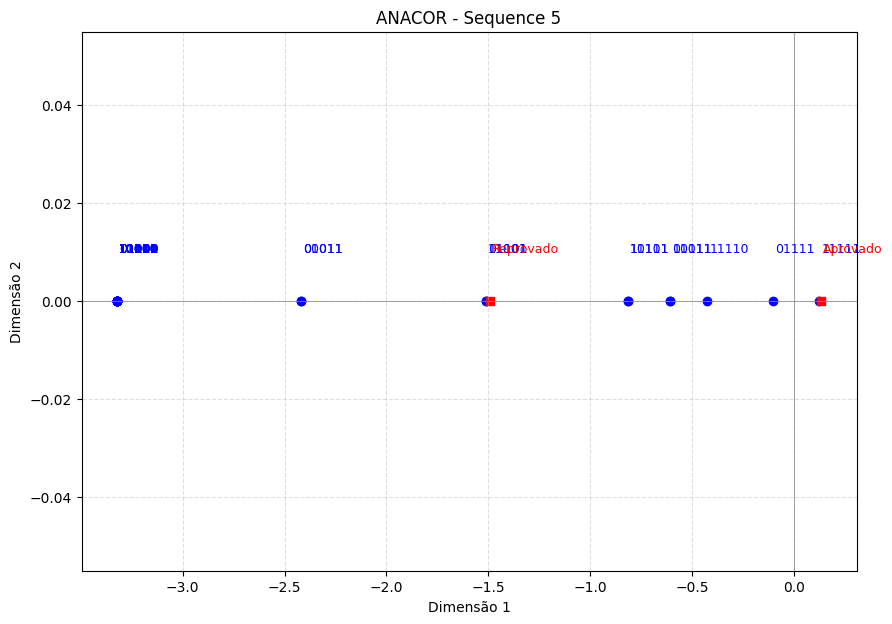


--- ANACOR: Level 0-5 ---
Chi2: 200.07460648855567 p-value: 2.0116439104119896e-45 dof: 1


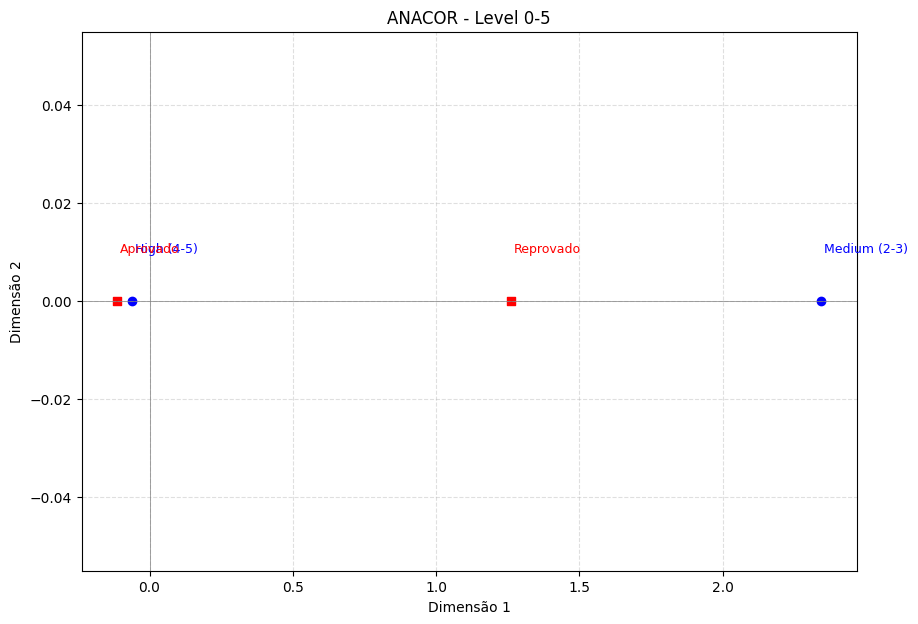

In [52]:
#Importações de bibliotecas
import re
import pandas as pd
import numpy as np
import prince
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Carrega dados com duas linhas de header
df = pd.read_excel('/content/Base anonimizada.xlsx', header=[0,1])

# Junta os dois níveis de header em uma única string por coluna
df.columns = ['_'.join([str(a).strip() for a in col if str(a) != 'nan']).strip() for col in df.columns]

# Função para identificar colunas de uma aula
def cols_for_aula(df, aula_num):
    pattern = re.compile(rf'^Aula\s*{aula_num}_', flags=re.IGNORECASE)
    return [c for c in df.columns if pattern.search(c)]

# Função de engajamento mais restritiva
def aula_engajada_values(values):
    joined = ' '.join([str(v).strip() for v in values if pd.notna(v)])
    if not joined:
        return 0
    tokens = joined.lower()
    positive_markers = ['√', 'p', ':-d', ':-)', ':d', 'pres', 'particip', 'ok', '1/2', '1/1']
    for m in positive_markers:
        if m in tokens:
            return 1
    return 0

# Calcula engajamento para as 5 primeiras aulas
n_first = 5
for i in range(1, n_first + 1):
    cols = cols_for_aula(df, i)
    if not cols:
        df[f'eng_aula_{i}'] = 0
    else:
        df[f'eng_aula_{i}'] = df[cols].apply(lambda row: aula_engajada_values(row.tolist()), axis=1)
    print(f"Aula {i} cols: {cols}")
    print(df[f'eng_aula_{i}'].unique())

# Sequência binária e contagem
df['eng_sequence_5'] = df[[f'eng_aula_{i}' for i in range(1, n_first+1)]].astype(int).apply(lambda r: ''.join(r.astype(str)), axis=1)
df['eng_count_5'] = df[[f'eng_aula_{i}' for i in range(1, n_first+1)]].sum(axis=1)

# Categoriza engajamento
def eng_cat(x):
    if pd.isna(x):
        return 'Missing'
    if x <= 1:
        return 'Low (0-1)'
    if x <= 3:
        return 'Medium (2-3)'
    return 'High (4-5)'

df['eng_level_5'] = df['eng_count_5'].apply(eng_cat)

# Coluna de desfecho
outcome_col = 'Aula 14_Situação Final'
df[outcome_col] = df[outcome_col].astype(str).str.strip().str.lower()
df[outcome_col] = df[outcome_col].replace({
    'aprovado': 'Aprovado',
    'aprov.': 'Aprovado',
    'reprovado': 'Reprovado',
    'reprov.': 'Reprovado'
})
df = df[df[outcome_col].isin(['Aprovado','Reprovado'])]
print(f"Número de linhas após filtro de desfecho: {len(df)}")

# Crosstabs
tabela_seq = pd.crosstab(df['eng_sequence_5'], df[outcome_col])
tabela_level = pd.crosstab(df['eng_level_5'], df[outcome_col])
print("\nTabela (Sequência 5 aulas x Situação Final):")
print(tabela_seq)
print("\nTabela (Nível agregado 0-5 x Situação Final):")
print(tabela_level)

# Função ANACOR segura
def run_anacor_and_plot(crosstab, title_suffix=''):
    if crosstab.empty or len(crosstab) < 2 or len(crosstab.columns) < 2:
        print(f"\nCrosstab insuficiente para {title_suffix}, pulando ANACOR.")
        return None, None, None, None, None, None

    ca = prince.CA(n_components=2, n_iter=10, copy=True, check_input=True, engine='scipy')
    ca = ca.fit(crosstab)

    chi2, p, dof, expected = chi2_contingency(crosstab)
    print(f"\n--- ANACOR: {title_suffix} ---")
    print("Chi2:", chi2, "p-value:", p, "dof:", dof)

    row_coords = ca.row_coordinates(crosstab)
    col_coords = ca.column_coordinates(crosstab)

    # Número de dimensões retornadas
    n_dim_row = row_coords.shape[1]
    n_dim_col = col_coords.shape[1]

    # Se só tem 1 dimensão, criar Dim2 = 0
    if n_dim_row < 2:
        row_coords['Dim2'] = 0
    if n_dim_col < 2:
        col_coords['Dim2'] = 0

    row_coords.columns = [f'Dim{i+1}' for i in range(row_coords.shape[1])]
    col_coords.columns = [f'Dim{i+1}' for i in range(col_coords.shape[1])]

    plt.figure(figsize=(10,7))
    plt.axhline(0, color='grey', lw=0.5)
    plt.axvline(0, color='grey', lw=0.5)

    for i, txt in enumerate(row_coords.index):
        plt.scatter(row_coords['Dim1'].iloc[i], row_coords['Dim2'].iloc[i], marker='o', color='blue')
        plt.text(row_coords['Dim1'].iloc[i]+0.01, row_coords['Dim2'].iloc[i]+0.01, str(txt), fontsize=9, color='blue')

    for i, txt in enumerate(col_coords.index):
        plt.scatter(col_coords['Dim1'].iloc[i], col_coords['Dim2'].iloc[i], marker='s', color='red')
        plt.text(col_coords['Dim1'].iloc[i]+0.01, col_coords['Dim2'].iloc[i]+0.01, str(txt), fontsize=9, color='red')

    plt.title(f'ANACOR - {title_suffix}')
    plt.xlabel('Dimensão 1')
    plt.ylabel('Dimensão 2')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()

    return ca, row_coords, col_coords, chi2, p, expected

# Executa ANACOR
ca_seq, row_coords_seq, col_coords_seq, chi2_seq, p_seq, exp_seq = run_anacor_and_plot(tabela_seq, title_suffix='Sequence 5')
ca_lvl, row_coords_lvl, col_coords_lvl, chi2_lvl, p_lvl, exp_lvl = run_anacor_and_plot(tabela_level, title_suffix='Level 0-5')
